# Chris Daigle
## Convex Optimization w/ Python
## Exam

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sympy import *

In [2]:
df = pd.read_csv(
    '/Users/daiglechris/Git/ConvexOptimizationWithPython/Data/Stocks2-closeP.csv', 
    sep = ",")

In [3]:
df.head()

,timestamp,F_close,BA_close,RTN_close,VLO_close,AAL_close,CI_close,IBM_close,PG_close
0,2018-12-03,9.60,359.96,172.87,81.30,39.65,224.84,125.31,93.32
1,2018-11-30,9.41,346.76,175.34,79.90,40.16,223.38,124.27,94.51
2,2018-11-29,9.37,342.56,173.58,79.47,38.42,222.52,121.48,92.82
3,2018-11-28,9.41,333.50,173.61,79.42,38.94,221.72,123.00,93.01
4,2018-11-27,9.28,318.03,171.67,77.43,38.29,216.80,120.03,92.72


### Question 1:
(a) Compute the one day returns $\left (\dfrac{p_{t+1}-p_{t}}{p_{t}} \right )$ of each stock and find the mean and the variance of each stock's returns.

In [4]:
oneDayReturns = df.iloc[:,1:].apply(lambda x: ((x - (x.shift(1))) / (x.shift(1))))
names = list(oneDayReturns.columns)
meansOfReturns = pd.DataFrame(oneDayReturns.describe().iloc[1].values,
                              index = names)
varianceOfReturns = oneDayReturns.var()
table = pd.concat([meansOfReturns, varianceOfReturns],
                  axis = 1)
table.columns = ['Mean of the Returns', 'Variance of the Returns']
table

,Mean of the Returns,Variance of the Returns
F_close,0.001533,0.000352
BA_close,-0.000098,0.000331
RTN_close,0.001566,0.000214
VLO_close,0.003054,0.000501
AAL_close,-0.000345,0.000649
CI_close,-0.002542,0.000194
IBM_close,0.001668,0.000267
PG_close,-0.001568,0.000145


|**Name of Stock**| **Mean of the Returns** | **Variance of the Returns**    |
|------------|:--------------------------------------------:|--------------:|
| Ford       | 0.001533| 0.000352  |
| Boeing     | 0.000098| 0.000331 |
| Raytheon       | 0.001566| 0.000214 |
| Valero Energy     | 0.003054 | 0.000501 |
| American Airlines       | -0.000345 | 0.000649  |
| Cigna     |-0.002542| 0.000194|
| IBM       | 0.001668| 0.000267 |
| Procter & Gamble     | -0.001568|0.000145|

(b) Plot the returns of the stocks with the two highest variance and the stocks with the two highest mean. Save a pdf copy of you graphs with “plt.savefig(ʼsample.pdfʼ). Send the pdf file to olivier.morand@uconn.edu with “graph-your name” in the title of your email.


In [5]:
highestVar = table.sort_values(by = 'Variance of the Returns',
                               axis = 0,
                               ascending=False).head(2)
highestMean = table.sort_values(by = 'Mean of the Returns',
                                axis = 0,
                                ascending=False).head(2)
dfHighest = pd.concat([highestMean, highestVar])
dfReturnHighest = oneDayReturns[dfHighest.T.columns]

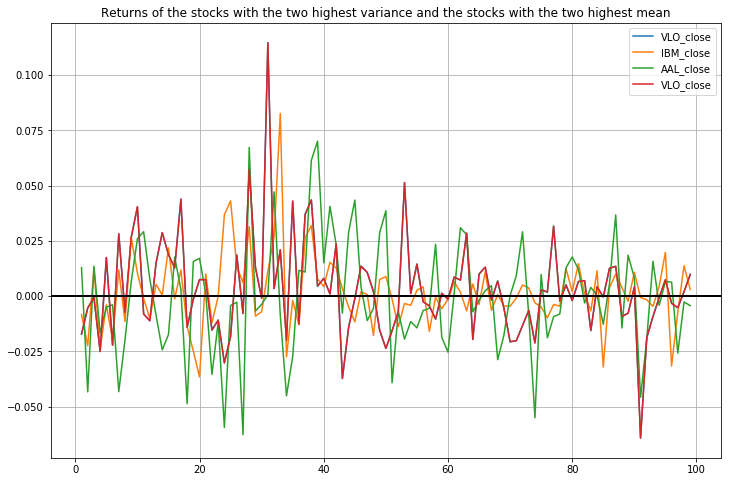

In [6]:
dfReturnHighest.plot(grid = True, 
                     figsize = (12,8)).axhline(y = 0, 
                                               color = "black", 
                                               lw = 2)
plt.title('Returns of the stocks with the two highest variance and the stocks with the two highest mean')
plt.savefig('graph-Daigle.pdf')
plt.show()

### Question 2:
Two clients, John and Jane, have asked you for help to build a portfolio in which to invest their income. You seek a combination of the 8 stocks that will maximize each clientʼs utility. A portfolio is a vector $X = (x_{1}, ..., x_{8})$ with $\forall i = 1, ... 8$, $0 \le x_{i} \le 1$ and $\sum_{i=1}^{8} x_{i} = 1$ where $x_{i}$ is the fraction of income to be spend on asset $i$. Both clients have utility: 
$$X.\overline{R}^{T} - \frac{1}{2}AX\Sigma X^{T}$$
where $\overline{R}$ is the $1 \times 8$ vector of means calculated in 1, and $\Sigma$ is the $8 \times 8$ covariance matrix of returns. John is risk averse and his risk coefficient is $A = 2$ while Jane's coefficient is $A = 10$.

(a) Explain below why the problem is convex.

The problem is convex because the Hessian Matrix of $X\Sigma X^{T}$ is positive semidefinite (PSD), $\frac{1}{2} A$ only scales the value of $X\Sigma X^{T}$, and the first portion $X.\overline{R}^{T}$ is just a vector of scalars, singleton or otherwise. So, we only need to evaluate the Hessian of $X\Sigma X^{T}$.

In [7]:
x1, x2, x3, x4, x5, x6, x7, x8 = symbols('ford, Boeing, Raytheon, Valero, AmericanAir, Cigna, IBM, PG')
X = np.array([x1, x2, x3, x4, x5, x6, x7, x8])
R = meansOfReturns
bigSigma = oneDayReturns.cov()
Z = np.array(X*bigSigma*X.T)

In [8]:
def hessian(x):
    """
    Calculate the hessian matrix with finite differences
    Parameters:
       - x : ndarray
    Returns:
       an array of shape (x.dim, x.ndim) + x.shape
       where the array[i, j, ...] corresponds to the second derivative x_ij
    """
    x_grad = np.gradient(x) 
    hessian = np.empty((x.ndim, x.ndim) + x.shape, dtype=x.dtype) 
    for k, grad_k in enumerate(x_grad):
        # iterate over dimensions
        # apply gradient again to every component of the first derivative.
        tmp_grad = np.gradient(grad_k) 
        for l, grad_kl in enumerate(tmp_grad):
            hessian[k, l, :, :] = grad_kl
    return hessian

In [9]:
H = hessian(np.array(bigSigma))
np.linalg.det(H)

array([[ 2.20799925e-63, -6.76560985e-48],
       [-7.95272270e-48, -3.57667386e-65]])

This works out to a series of zeros in the matrix. I'm not sure why there are 4 values, but regardless, zero times any real value is zero and thus, the matrix is PSD and the problem is thus convex.